<a href="https://colab.research.google.com/github/joshkatzenbach/nba_win_prediction/blob/main/NBA_Neural_Network.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
!pip install pytorch-tabnet
import torch
import torch.nn as nn
import torch.optim as optim
import torchvision
import torchvision.transforms as transforms
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import io
from google.colab import files
from google.colab import drive
from torch.utils.data import Dataset, DataLoader
from pytorch_tabnet.tab_model import TabNetClassifier, TabNetRegressor
import numpy as np
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score
from sklearn.preprocessing import StandardScaler
drive.mount('/content/drive')



   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 44.5/44.5 kB 1.8 MB/s eta 0:00:00
Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


In [ ]:
#Importing Data
file_path = '/content/drive/My Drive/combined_data.xlsx'
sheet_name = 'All'
master_df = pd.read_excel(file_path, sheet_name=sheet_name)


In [ ]:
device = "cpu"

Options For Output:

- Final Score
- All Final Stats
- Difference in scores for Final Score
- Winner


I was working on the accuracy and validation functions when I last left off.



In [ ]:
# Create DataSet Class

class Basketball_DataSet(Dataset):
  def __init__(self, input, output):
    self.x = input
    self.y = output

  def __len__(self):
    return len(self.x)

  def __getitem__(self, idx):
    sample_x = self.x[idx]
    sample_y = self.y[idx]
    return sample_x, sample_y



In [ ]:
def baseline_accuracy(dataset):
  total_correct = 0
  for i in range(len(dataset)):
    home_win = False
    home_pred_win = False
    x = dataset[i][0]
    y_truth = dataset[i][1]
    home_halftime_points = x[46]
    away_halftime_points = x[93]
    home_points = y_truth[0]
    away_points = y_truth[1]


    # if i == 0:
    #   print(home_halftime_points)
    #   print(away_halftime_points)
    #   print(home_points)
    #   print(away_points)

    if home_halftime_points >= away_halftime_points:
      home_pred_win = True

    if home_points >= away_points:
      home_win = True

    if home_win == home_pred_win:
      total_correct += 1


  return float(total_correct) / len(dataset)






In [ ]:
# DATA



q1_column_names = ["Content.Home Q1 fg", "Content.Home Q1 fga", "Content.Home Q1 fg3", "Content.Home Q1 fg3a", "Content.Home Q1 ft", "Content.Home Q1 fta", "Content.Home Q1 orb", "Content.Home Q1 drb", "Content.Home Q1 trb",
                   "Content.Home Q1 ast", "Content.Home Q1 stl", "Content.Home Q1 blk", "Content.Home Q1 tov", "Content.Home Q1 pf", "Content.Home Q1 pts",
                   "Content.Away Q1 fg", "Content.Away Q1 fga", "Content.Away Q1 fg3", "Content.Away Q1 fg3a", "Content.Away Q1 ft", "Content.Away Q1 fta", "Content.Away Q1 orb", "Content.Away Q1 drb", "Content.Away Q1 trb",
                   "Content.Away Q1 ast", "Content.Away Q1 stl", "Content.Away Q1 blk", "Content.Away Q1 tov", "Content.Away Q1 pf", "Content.Away Q1 pts"]

home_stat_column_names = ["Content.Home fg", "Content.Home fga", "Content.Home fg3", "Content.Home fg3a", "Content.Home ft", "Content.Home fta", "Content.Home orb", "Content.Home drb", "Content.Home trb",
                   "Content.Home ast", "Content.Home stl", "Content.Home blk", "Content.Home tov", "Content.Home pf", "Content.Home pts"]

away_stat_column_names = ["Content.Away fg", "Content.Away fga", "Content.Away fg3", "Content.Away fg3a", "Content.Away ft", "Content.Away fta", "Content.Away orb", "Content.Away drb", "Content.Away trb",
                   "Content.Away ast", "Content.Away stl", "Content.Away blk", "Content.Away tov", "Content.Away pf", "Content.Away pts"]


print(len(q1_column_names))

# Set Validation set size
val_percentage = .15
random_state_id = 12

# Drop unnecessary data columns
basic_df = master_df.drop(['Content.GameID', 'Content.Date','Content.Away Team', 'Content.Home Team', 'Name'], axis = 1) # Get rid of GameID and Date columns
#print("Num Rows: " + str(len(basic_df)))
basic_df = basic_df[ # Get rid of any games that have teams that have not played any games.
    ((basic_df["Content.Home Wins"] != 0) | (basic_df["Content.Home Losses"] != 0)) &
    ((basic_df["Content.Away Wins"] != 0) | (basic_df["Content.Away Losses"] != 0))
]
print("Total Data Size: " + str(len(basic_df)))

# Create Validation and Training DataFrames

val_size = int(len(basic_df) * val_percentage)

val_df = basic_df.sample(val_size, random_state=random_state_id)
train_df = basic_df.drop(val_df.index).reset_index(drop=True)
val_df = val_df.reset_index(drop=True)


print("Training set size: " + str(len(train_df)))
print("Validation set size " + str(len(val_df)))


#Categories of Data

  # X Values
    # Full
    # Q1 Omitted
    # Full Normalized
    # Q1 Omitted Normalized

  # Y Data
    # Normal 2 Output
    # Point Dif 1 ouput
    # BCE binary 1 ouput


# Separate X and Y
output_col_names = basic_df.columns[47:62].to_list() + basic_df.columns[109:124].to_list()
sel_output_col_names = ["Content.Home pts", "Content.Away pts"]

#print(output_col_names)
val_y = val_df[sel_output_col_names]
val_x = val_df.drop(output_col_names, axis = 1)
train_y = train_df[sel_output_col_names]
train_x = train_df.drop(output_col_names, axis = 1)
print("Full Data Input Dimensionality: " + str(len(train_x.columns)))
print("Full Data Output Dimensionality: " + str(len(train_y.columns)))

# Make data omitting q1
val_x_omit_q1 = val_x.drop(q1_column_names, axis = 1)
train_x_omit_q1 = train_x.drop(q1_column_names, axis = 1)

# Make Output Data with one output
dif_val_y = (val_y["Content.Home pts"] - val_y["Content.Away pts"]).to_frame()
dif_train_y = (train_y["Content.Home pts"] - train_y["Content.Away pts"]).to_frame()

# Make this data binary:
bce_train_y = (dif_train_y > 0).astype(int)
bce_val_y = (dif_val_y > 0).astype(int)



#Normalizing data
scaler = StandardScaler()

train_x_norm = scaler.fit_transform(train_x)
val_x_norm = scaler.fit_transform(val_x)
train_x_omit_q1_norm = scaler.fit_transform(train_x_omit_q1)
val_x_omit_q1_norm = scaler.fit_transform(val_x_omit_q1)

# Scaling Y shouldn't be necessary
# train_y_dif_norm = scaler.fit_transform(dif_train_y)
# val_y_dif_norm = scaler.fit_transform(dif_val_y)



# Full Data Sets
train_dataset = Basketball_DataSet(torch.tensor(train_x.to_numpy(), dtype = torch.float32), torch.tensor(train_y.to_numpy(), dtype = torch.float32))
val_dataset = Basketball_DataSet(torch.tensor(val_x.to_numpy(), dtype = torch.float32), torch.tensor(val_y.to_numpy(), dtype = torch.float32))

#Q1 Omitted datasets
train_dataset_omit_q1 = Basketball_DataSet(torch.tensor(train_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(train_y.to_numpy(), dtype = torch.float32))
val_dataset_omit_q1 = Basketball_DataSet(torch.tensor(val_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(val_y.to_numpy(), dtype = torch.float32))

# Full Data Sets with difs
train_dataset_dif = Basketball_DataSet(torch.tensor(train_x.to_numpy(), dtype = torch.float32), torch.tensor(dif_train_y.to_numpy(), dtype = torch.float32))
val_dataset_dif = Basketball_DataSet(torch.tensor(val_x.to_numpy(), dtype = torch.float32), torch.tensor(dif_val_y.to_numpy(), dtype = torch.float32))

# Q1 omitted with dif data sets
train_dataset_dif_omit_q1 = Basketball_DataSet(torch.tensor(train_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(dif_train_y.to_numpy(), dtype = torch.float32))
val_dataset_dif_omit_q1 = Basketball_DataSet(torch.tensor(val_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(dif_val_y.to_numpy(), dtype = torch.float32))

# # Normalized Full Data sets with dif
train_dataset_dif_norm = Basketball_DataSet(torch.tensor(train_x_norm, dtype = torch.float32), torch.tensor(dif_train_y.to_numpy(), dtype = torch.float32))
val_dataset_dif_norm = Basketball_DataSet(torch.tensor(val_x_norm, dtype = torch.float32), torch.tensor(dif_val_y.to_numpy(), dtype = torch.float32))

# Normalized Q1 Omit with dif
train_dataset_omit_q1_dif_norm = Basketball_DataSet(torch.tensor(train_x_omit_q1_norm, dtype = torch.float32), torch.tensor(dif_train_y.to_numpy(), dtype = torch.float32))
val_dataset_omit_q1_dif_norm = Basketball_DataSet(torch.tensor(val_x_omit_q1_norm, dtype = torch.float32), torch.tensor(dif_val_y.to_numpy(), dtype = torch.float32))

# train_dataset_dif_norm = Basketball_DataSet(torch.tensor(train_x_norm, dtype = torch.float32), torch.tensor(train_y_dif_norm, dtype = torch.float32))
# val_dataset_dif_norm = Basketball_DataSet(torch.tensor(val_x_norm, dtype = torch.float32), torch.tensor(val_y_dif_norm, dtype = torch.float32))

# BCE Full Norm
train_dataset_bce_norm = Basketball_DataSet(torch.tensor(train_x_norm, dtype = torch.float32), torch.tensor(bce_train_y.to_numpy(), dtype = torch.float32))
val_dataset_bce_norm = Basketball_DataSet(torch.tensor(val_x_norm, dtype = torch.float32), torch.tensor(bce_val_y.to_numpy(), dtype = torch.float32))

# BCE Omit Norm
train_dataset_bce_norm_omit_q1 = Basketball_DataSet(torch.tensor(train_x_omit_q1_norm, dtype = torch.float32), torch.tensor(bce_train_y.to_numpy(), dtype = torch.float32))
val_dataset_bce_norm_omit_q1 = Basketball_DataSet(torch.tensor(val_x_omit_q1_norm, dtype = torch.float32), torch.tensor(bce_val_y.to_numpy(), dtype = torch.float32))







# print("Omit Q1 Data Input Dimensionality: " + str(len(train_x_omit_q1.columns)))
# print("Omit Q1 Data Output Dimensionality: " + str(len(train_y.columns)))









30
Total Data Size: 31764
Training set size: 27000
Validation set size 4764
Full Data Input Dimensionality: 94
Full Data Output Dimensionality: 2


In [ ]:
def get_temporal_data(data, num_games, home_stats, away_stats):
  home_team_data = []
  away_team_data = []
  for i in range(len(data)):
    home_team_data.append([np.zeros(15), 0])
    away_team_data.append([np.zeros(15), 0])

  big_count = 0
  for i, row in data.iterrows():
    home_team = row["Content.Home Team"]
    away_team = row["Content.Away Team"]
    home_stat_vals = data.iloc[i][home_stats].values
    away_stat_vals = data.iloc[i][away_stats].values
    home_count = 0
    away_count = 0
    big_count += 1

    # if i == 0:
    #   print(home_stat_vals)


    for j in range(i + 1, len(data)):
      row_data = data.iloc[j][["Content.Home Team", "Content.Away Team", "Content.Home Avg fg", "Content.Away Avg fg"]].to_numpy()
      home_team_2 = row_data[0]
      away_team_2 = row_data[1]

      # Check to see if season has ended
      if (home_team_2 == home_team or home_team_2 == away_team) and row_data[2] == 0:
        break
      elif(away_team_2 == home_team or away_team_2 == away_team) and row_data[3] == 0:
        break

      # If the original Home team is found
      if home_team_2 == home_team and home_count < num_games:
        home_team_data[j][0] = np.add(home_team_data[j][0], home_stat_vals)
        home_count += 1
        home_team_data[j][1] += 1
      elif away_team_2 == home_team and home_count < num_games:
        away_team_data[j][0] = np.add(away_team_data[j][0], home_stat_vals)
        home_count += 1
        away_team_data[j][1] += 1


      if home_team_2 == away_team and away_count < num_games:
        home_team_data[j][0] = np.add(home_team_data[j][0], away_stat_vals)
        away_count += 1
        home_team_data[j][1] += 1
      elif away_team_2 == away_team and away_count < num_games:
        away_team_data[j][0] = np.add(away_team_data[j][0], away_stat_vals)
        away_count += 1
        away_team_data[j][1] += 1

      # If we found all the games, break the loop
      if home_count >= num_games and away_count >= num_games:
        break

    if big_count % 2000 == 0:
      print(big_count)
    # if big_count >= 1600:
    #   break


  for i in range(len(data)):
    if (home_team_data[i][1] != 0):
      home_team_data[i][0] = home_team_data[i][0] / home_team_data[i][1]

    if (away_team_data[i][1] != 0):
      away_team_data[i][0] = away_team_data[i][0] / away_team_data[i][1]

  return home_team_data, away_team_data




home_team_data, away_team_data = get_temporal_data(master_df, 5, home_stat_column_names, away_stat_column_names)

2000
4000
6000
8000
10000
12000
14000
16000
18000
20000
22000
24000
26000
28000
30000
32000


In [ ]:
home_team_data[11675]

[array([37.6, 86.6, 10.6, 29.4, 15.8, 21.8, 10.8, 29.6, 40.4, 24.4, 9.2,
        1.2, 14.4, 21.0, 101.6], dtype=object),
 5]

In [ ]:
home_stat_column_names = ["Temp.Home fg", "Temp.Home fga", "Temp.Home fg3", "Temp.Home fg3a", "Temp.Home ft", "Temp.Home fta", "Temp.Home orb", "Temp.Home drb", "Temp.Home trb",
                   "Temp.Home ast", "Temp.Home stl", "Temp.Home blk", "Temp.Home tov", "Temp.Home pf", "Temp.Home pts"]

away_stat_column_names = ["Temp.Away fg", "Temp.Away fga", "Temp.Away fg3", "Temp.Away fg3a", "Temp.Away ft", "Temp.Away fta", "Temp.Away orb", "Temp.Away drb", "Temp.Away trb",
                   "Temp.Away ast", "Temp.Away stl", "Temp.Away blk", "Temp.Away tov", "Temp.Away pf", "Temp.Away pts"]


new_home_data = []
new_away_data = []
for i in range(len(home_team_data)):
  new_home_data.append(home_team_data[i][0])
  new_away_data.append(away_team_data[i][0])



extra_home_df = pd.DataFrame(new_home_data, columns = home_stat_column_names)
extra_away_df = pd.DataFrame(new_away_data, columns = away_stat_column_names)
extra_df_combined = pd.concat([extra_home_df, extra_away_df], axis = 1)
complete_extra_df = pd.concat([master_df, extra_df_combined], axis = 1)

extra_df = complete_extra_df.drop(['Content.GameID', 'Content.Date','Content.Away Team', 'Content.Home Team', 'Name'], axis = 1) # Get rid of GameID and Date columns
extra_df = extra_df[ # Get rid of any games that have teams that have not played any games.
    ((extra_df["Content.Home Wins"] != 0) | (extra_df["Content.Home Losses"] != 0)) &
    ((extra_df["Content.Away Wins"] != 0) | (extra_df["Content.Away Losses"] != 0))
]

val_size = int(len(basic_df) * val_percentage)

extra_val_df = extra_df.sample(val_size, random_state=random_state_id)
extra_train_df = extra_df.drop(extra_val_df.index).reset_index(drop=True)
extra_val_df = extra_val_df.reset_index(drop=True)

print("Training set size: " + str(len(train_df)))
print("Validation set size " + str(len(val_df)))

# Separate X and Y
output_col_names = basic_df.columns[47:62].to_list() + basic_df.columns[109:124].to_list()
sel_output_col_names = ["Content.Home pts", "Content.Away pts"]

#print(output_col_names)
extra_val_y = extra_val_df[sel_output_col_names]
extra_val_x = extra_val_df.drop(output_col_names, axis = 1)
extra_train_y = extra_train_df[sel_output_col_names]
extra_train_x = extra_train_df.drop(output_col_names, axis = 1)
print("Full Data Input Dimensionality: " + str(len(extra_train_x.columns)))
print("Full Data Output Dimensionality: " + str(len(extra_train_y.columns)))


extra_val_x_omit_q1 = extra_val_x.drop(q1_column_names, axis = 1)
extra_train_x_omit_q1 = extra_train_x.drop(q1_column_names, axis = 1)

# Set Dif Mode
extra_dif_val_y = (extra_val_y["Content.Home pts"] - extra_val_y["Content.Away pts"]).to_frame()
extra_dif_train_y = (extra_train_y["Content.Home pts"] - extra_train_y["Content.Away pts"]).to_frame()

#Normalizing data
scaler = StandardScaler()

extra_train_x_norm = scaler.fit_transform(extra_train_x)
extra_val_x_norm = scaler.fit_transform(extra_val_x)
extra_train_x_omit_q1_norm = scaler.fit_transform(extra_train_x_omit_q1)
extra_val_x_omit_q1_norm = scaler.fit_transform(extra_val_x_omit_q1)




# Extra Basic Data Sets
extra_train_dataset = Basketball_DataSet(torch.tensor(extra_train_x.to_numpy(), dtype = torch.float32), torch.tensor(extra_train_y.to_numpy(), dtype = torch.float32))
extra_val_dataset = Basketball_DataSet(torch.tensor(extra_val_x.to_numpy(), dtype = torch.float32), torch.tensor(extra_val_y.to_numpy(), dtype = torch.float32))

# Extra Dif
extra_train_dataset_dif = Basketball_DataSet(torch.tensor(extra_train_x.to_numpy(), dtype = torch.float32), torch.tensor(extra_dif_train_y.to_numpy(), dtype = torch.float32))
extra_val_dataset_dif = Basketball_DataSet(torch.tensor(extra_val_x.to_numpy(), dtype = torch.float32), torch.tensor(extra_dif_val_y.to_numpy(), dtype = torch.float32))

# Extra Dif Norm
extra_train_dataset_dif_norm = Basketball_DataSet(torch.tensor(extra_train_x_norm, dtype = torch.float32), torch.tensor(extra_dif_train_y.to_numpy(), dtype = torch.float32))
extra_val_dataset_dif_norm = Basketball_DataSet(torch.tensor(extra_val_x_norm, dtype = torch.float32), torch.tensor(extra_dif_val_y.to_numpy(), dtype = torch.float32))


# Omitting Q1 Data
extra_train_dataset_omit_q1 = Basketball_DataSet(torch.tensor(extra_train_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(extra_train_y.to_numpy(), dtype = torch.float32))
extra_val_dataset_omit_q1 = Basketball_DataSet(torch.tensor(extra_val_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(extra_val_y.to_numpy(), dtype = torch.float32))

# Omitting Dif
extra_train_dataset_omit_q1_dif = Basketball_DataSet(torch.tensor(extra_train_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(extra_dif_train_y.to_numpy(), dtype = torch.float32))
extra_val_dataset_omit_q1_dif = Basketball_DataSet(torch.tensor(extra_val_x_omit_q1.to_numpy(), dtype = torch.float32), torch.tensor(extra_dif_val_y.to_numpy(), dtype = torch.float32))

# normalized
extra_train_dataset_omit_q1_dif_norm = Basketball_DataSet(torch.tensor(extra_train_x_omit_q1_norm, dtype = torch.float32), torch.tensor(extra_dif_train_y.to_numpy(), dtype = torch.float32))
extra_val_dataset_omit_q1_dif_norm = Basketball_DataSet(torch.tensor(extra_val_x_omit_q1_norm, dtype = torch.float32), torch.tensor(extra_dif_val_y.to_numpy(), dtype = torch.float32))









Training set size: 27000
Validation set size 4764
Full Data Input Dimensionality: 124
Full Data Output Dimensionality: 2


In [ ]:
print(home_team_data[1300])
print(away_team_data[100])

[array([28.0, 79.5, 5.0, 15.0, 14.5, 18.0, 12.5, 22.0, 34.5, 17.0, 7.5,
       1.5, 15.0, 26.0, 75.5], dtype=object), 2]
[array([34.0, 79.0, 5.2, 17.0, 21.2, 27.8, 12.0, 35.0, 47.0, 19.4, 9.6,
       7.0, 18.4, 23.2, 94.4], dtype=object), 5]


In [ ]:
print(baseline_accuracy(val_dataset))

0.714735516372796


In [ ]:
class BasicNet(nn.Module):
  def __init__(self, input_features, intermediate_features, output_features, num_hidden_layers):
    super().__init__()
    self.input_layer = nn.Linear(input_features, intermediate_features)
    self.inputReLU = nn.ReLU()
    self.hidden_layers = nn.ModuleList([nn.Linear(intermediate_features, intermediate_features) for i in range(num_hidden_layers)])
    self.ReLU_layers = nn.ModuleList([nn.ReLU() for i in range(num_hidden_layers)])
    self.output_layer = nn.Linear(intermediate_features, output_features)
    self.num_hidden_layers = num_hidden_layers

  def forward(self, x):
    x = self.input_layer(x)
    x = self.inputReLU(x)
    for i in range(self.num_hidden_layers):
      x = self.hidden_layers[i](x)
      x = self.ReLU_layers[i](x)
    output = self.output_layer(x)
    return output

In [ ]:
def accuracy_2_outputs(y_pred_batch, y_true_batch):
  correct : float = 0

  # Calculate accuracy based on a correct prediction of the game winner
  for i in range(y_true_batch.shape[0]):
    y_pred = y_pred_batch[i]
    y_true = y_true_batch[i]

    if y_pred[0] > y_pred[1] and y_true[0] > y_true[1]:
      correct += 1
    elif y_pred[0] < y_pred[1] and y_true[0] < y_true[1]:
      correct += 1

  accuracy = correct / y_true_batch.shape[0]
  return correct, y_true_batch.shape[0], accuracy

def accuracy_1_output(y_pred_batch, y_true_batch):
  correct : float = 0

  for i in range(y_true_batch.shape[0]):
    y_pred = y_pred_batch[i]
    y_true = y_true_batch[i]

    if y_pred > 0 and y_true > 0:
      correct += 1
    elif y_pred < 0 and y_true < 0:
      correct += 1

  accuracy = correct / y_true_batch.shape[0]
  return correct, y_true_batch.shape[0], accuracy

def accuracy_BCE(y_pred_batch, y_true_batch):
  correct : float = 0
  for i in range(y_true_batch.shape[0]):
    y_pred = y_pred_batch[i]
    y_true = y_true_batch[i]

    if y_pred >= .5 and y_true == 1:
      correct += 1
    elif y_pred < .5 and y_true == 0:
      correct += 1

  accuracy = correct / y_true_batch.shape[0]
  return correct, y_true_batch.shape[0], accuracy


In [ ]:
@torch.no_grad()
def validate(model, dataLoader, acc_fn):
  total_loss = 0
  total_correct_samples = 0
  total_samples = 0
  loss_fn = nn.MSELoss(reduction = 'sum')
  for batch in dataLoader:
    # Separate X and Y from batch
    x = batch[0].to(device)
    y_truth = batch[1].to(device)

    # Run Model
    y_hat = model(x)

    # Calculate Accuracy
    correct_samples, samples, _ = acc_fn(y_hat, y_truth)
    total_correct_samples += correct_samples
    total_samples += samples

    # Calculate Loss
    loss = loss_fn(y_hat, y_truth)
    total_loss += loss.item()

  average_loss = total_loss / len(dataLoader.dataset)
  accuracy = total_correct_samples / total_samples

  return average_loss, accuracy

@torch.no_grad()
def validate_BCE(model, dataLoader, acc_fn):
  loss_fn = nn.BCEWithLogitsLoss(reduction = 'sum')
  total_loss = 0
  total_correct_samples = 0
  total_samples = 0
  for batch in dataLoader:
    # Separate Data
    x = batch[0].to(device)
    y_truth = batch[1].to(device)

    # Run Model
    y_hat = model(x)

    #Calculate Accuracy
    correct_samples, samples, _ = acc_fn(y_hat, y_truth)
    total_correct_samples += correct_samples
    total_samples += samples

        # Calculate Loss
    loss = loss_fn(y_hat, y_truth)
    total_loss += loss.item()

  average_loss = total_loss / len(dataLoader.dataset)
  accuracy = total_correct_samples / total_samples

  return average_loss, accuracy






In [ ]:

def train(model, optimizer, epochs, dataloader, val_dataloader, val_interval, acc_fn):
  losses = []
  accs = []
  val_losses = []
  val_accs = []
  step = 0
  total_steps = epochs * len(dataloader)
  #print(len(dataloader))

  loss_fn = nn.MSELoss()

  for epoch in range(epochs):
    for batch in dataloader:


      # Separate X and Y values
      x = batch[0].to(device)
      y_truth = batch[1].to(device)

      # Run the Model
      y_hat = model(x)

      # Match Shapes
      if len(y_truth.shape) == 1:
        y_truth = y_truth.unsqueeze(1)

      # Calculate Losses
      loss = loss_fn(y_hat, y_truth)
      losses.append(loss.item())


      # Calculate Accuracies
      _, _ , acc = acc_fn(y_hat, y_truth)
      accs.append(acc)

      # Back-propagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if step % val_interval == 0:
        with torch.no_grad():
          val_loss, val_acc = validate(model, val_dataloader, acc_fn)
          val_losses.append(val_loss)
          val_accs.append(val_acc)
        model.train()

      # Keep track of total steps
      step += 1

      # Progress Bar
      # length = 50
      # percent = step / total_steps
      # bar_length = percent * 50
      # bar = '=' * int(bar_length) + '>' + ' ' * (length - int(bar_length))
      # print("f'\r |" + bar + "|  " + str(int(percent * 100)) + "%", end ='')



  return losses, accs, val_losses, val_accs








In [ ]:
def train_BCE(model, optimizer, epochs, dataloader, val_dataloader, val_interval, acc_fn):
  losses = []
  accs = []
  val_losses = []
  val_accs = []
  step = 0
  total_steps = epochs * len(dataloader)
  #print(len(dataloader))

  loss_fn = nn.BCEWithLogitsLoss()

  for epoch in range(epochs):
    for batch in dataloader:


      # Separate X and Y values
      x = batch[0].to(device)
      y_truth = batch[1].to(device)

      # Run the Model
      y_hat = model(x)

      # Match Shapes
      if len(y_truth.shape) == 1:
        y_truth = y_truth.unsqueeze(1)

      # Calculate Losses
      loss = loss_fn(y_hat, y_truth)
      losses.append(loss.item())


      # Calculate Accuracies
      _, _ , acc = acc_fn(y_hat, y_truth)
      accs.append(acc)

      # Back-propagation
      optimizer.zero_grad()
      loss.backward()
      optimizer.step()

      if step % val_interval == 0:
        with torch.no_grad():
          val_loss, val_acc = validate_BCE(model, val_dataloader, acc_fn)
          val_losses.append(val_loss)
          val_accs.append(val_acc)
        model.train()

      # Keep track of total steps
      step += 1

      # Progress Bar
      # length = 50
      # percent = step / total_steps
      # bar_length = percent * 50
      # bar = '=' * int(bar_length) + '>' + ' ' * (length - int(bar_length))
      # print("f'\r |" + bar + "|  " + str(int(percent * 100)) + "%", end ='')



  return losses, accs, val_losses, val_accs

In [ ]:
def plot_results(losses, accs, val_losses, val_accs, val_interval):

  y_lim = 300

  train_x = np.linspace(0, len(losses), num = len(losses))

  fig, axes = plt.subplots(2, 2, figsize = (10, 10))
  axes[0, 0].plot(train_x, losses)
  axes[0, 0].set_title('Training Loss')
  axes[0, 0].set_ylim(0, y_lim)

  axes[0, 1].plot(train_x, accs)
  axes[0, 1].set_title('Training Accuracy')


  val_x = np.linspace(0, val_interval * len(val_losses), len(val_losses))

  axes[1, 0].plot(val_x, val_losses)
  axes[1, 0].set_title('Validation Loss')
  axes[1, 0].set_ylim(0, y_lim)

  axes[1, 1].plot(val_x, val_accs)
  axes[1, 1].set_title('Validation Accuracy')

  plt.tight_layout()
  plt.show()
  # print("Training Loss Length: " + str(len(losses)))
  # print("Training Accuracy Length: " + str(len(accs)))
  # print("Validation Loss Length: " + str(len(val_losses)))
  #print("Validation Accuracy Length: " + str(len(val_accs)))
  print("Training Loss: " + str(losses[-1]))
  print("Validation Loss: " + str(val_losses[-1]))
  print("Validation Accuracy: " + str(val_accs[-1]))
  print("Maximum Validation Accuracy: " + str(max(val_accs)))
  print("Baseline Accuracy: " + str(baseline_accuracy(val_dataset)))

def plot_val_acc(val_accs, val_interval, name):
  val_x = np.linspace(0, val_interval * len(val_accs), len(val_accs))
  plt.plot(val_x, val_accs)
  plt.title(name + ": Val Accuracy")
  plt.show()



In [ ]:
class BasicNet2(nn.Module):
  def __init__(self, input_features, output_features):
    super().__init__()
    self.input_layer = nn.Linear(input_features, 90)
    self.layer2 = nn.Sequential(nn.ReLU(), nn.Linear(90, 70), nn.ReLU(), nn.Linear(70, 50), nn.ReLU(), nn.Linear(50, 30), nn.ReLU(), nn.Linear(30, 10), nn.ReLU(), nn.Linear(10, output_features))


  def forward(self, x):
    x = self.input_layer(x)
    output = self.layer2(x)

    return output

In [ ]:
class BatchNormNet(nn.Module):
  def __init__(self, input_features, intermediate_features, output_features, num_hidden_layers):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(input_features, intermediate_features), nn.BatchNorm1d(intermediate_features), nn.ReLU(), nn.Linear(intermediate_features, output_features))


  def forward(self, x):
    output = self.layers(x)

    return output


In [ ]:
class BCENet(nn.Module):
  def __init__(self, input_features, intermediate_features, output_features, num_hidden_layers):
    super().__init__()
    self.layers = nn.Sequential(nn.Linear(input_features, intermediate_features), nn.ReLU(), nn.Linear(intermediate_features, output_features))


  def forward(self, x):
    output = self.layers(x)

    return output

In [ ]:
#Full DataSet

# Hyperparameters
batch_size = 32
hidden_layers = 2
intermediate_features = 90
input_features = 94
output_features = 2
learning_rate = .001
epochs = 20
val_interval_batches = 100


# Instantiate DataLoaders
train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)


# Instantiate Model
model = BasicNet(input_features, intermediate_features, output_features, hidden_layers)
model.to(device)

# Instantiate Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Train
losses, accs, val_losses, val_accs = train(model, optimizer, epochs, train_dataloader, val_dataloader, val_interval_batches, accuracy_2_outputs)

# Plot

plot_results(losses, accs, val_losses, val_accs, val_interval_batches)


ERROR:root:Internal Python error in the inspect module.
Below is the traceback from this internal error.



Traceback (most recent call last):



KeyboardInterrupt



In [ ]:
def progress_bar(step, total_steps):
    length = 50
    percent = step / total_steps
    bar_length = percent * length
    bar = '=' * int(bar_length) + '>' + ' ' * (length - int(bar_length))
    print("f'\r |" + bar + "|  " + str(int(percent * 100)) + "%", end ='')
    step += 1
    return step

In [ ]:
def run_model(name, train_dataset, validation_dataset, acc_fn, net, input_features, output_features, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr):

  # Instantiate Dataloaders
  train_dataloader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
  val_dataloader = DataLoader(validation_dataset, batch_size = batch_size, shuffle = False)

  sum_accs_plot = []
  last_accs = []

  for i in range(num_cycles):
    # Instantiate Model and Optimizer
    model = net(input_features, intermediate_features, output_features, hidden_layers)
    model.to(device)
    optimizer = optim.Adam(model.parameters(), lr = learning_rate)

    # run model
    losses, accs, val_losses, val_accs = train(model, optimizer, epochs, train_dataloader, val_dataloader, interval, acc_fn)

    # Add Accuracies across trials
    if i == 0:
      sum_accs_plot = val_accs
    else:
      sum_accs_plot = np.add(sum_accs_plot, val_accs)

    # Average last accs
    last_accs.append(np.mean(val_accs[-last_acc_num:]))


  # Calculate Plot points
  avg_accs_plot = np.array(sum_accs_plot) / num_cycles

  avg_last_accs = sum(last_accs) / len(last_accs)

  improvement = (avg_last_accs - baseline_accuracy(val_dataset)) * 100

  improvement_str = name + " improvement: " + str(improvement)

  return (avg_accs_plot, improvement_str, name)

 |==================================================>|  100% 
Full improvement: 1.1999720123145763
Full Dif improvement: 1.6677162048698735
Full Dif Batchnorm improvement: 1.8484116988525146
Full Dif Normalized improvement: 1.9024629163168272
Full Dif Batchnorm Normalized improvement: 1.8302197033305379
Full BCE Normalized improvement: 1.671564511614887
Omit Q1 improvement: 1.4578085642317329
Omit Q1 Dif improvement: 1.7236915757066873
Omit Q1 Dif Norm improvement: 1.9096347607052921
Omit Q1 Dif Batchnorm improvement: 1.807129862860346
Omit Q1 Dif Batchnorm Norm improvement: 1.761999720123153
Omit Q1 BCE Norm improvement: 1.8784984606772914
Extra improvement: 1.0806745032185705
Extra Dif improvement: 1.62118667786173
Extra Dif Normalized improvement: 1.9582633641197722
Extra Omit improvement: 1.2293590820039113
Extra Omit Dif improvement: 1.7068989644556276
Extra Omit Dif Norm improvement: 1.9203050657710663


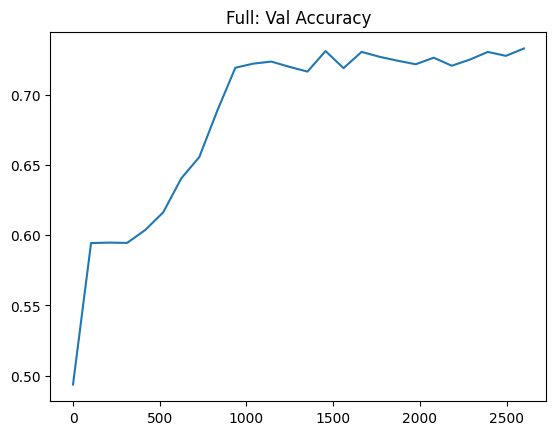

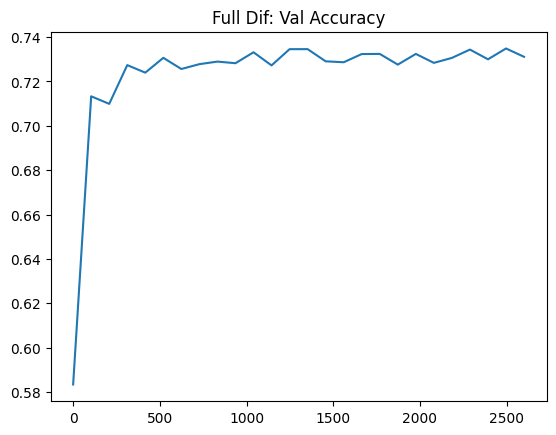

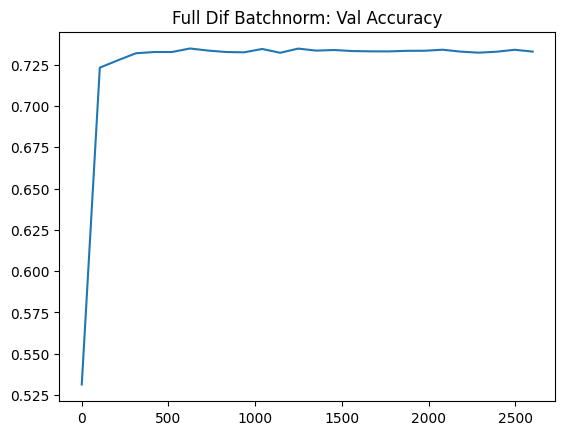

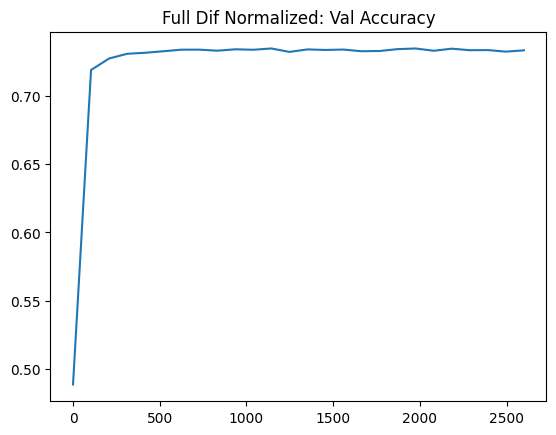

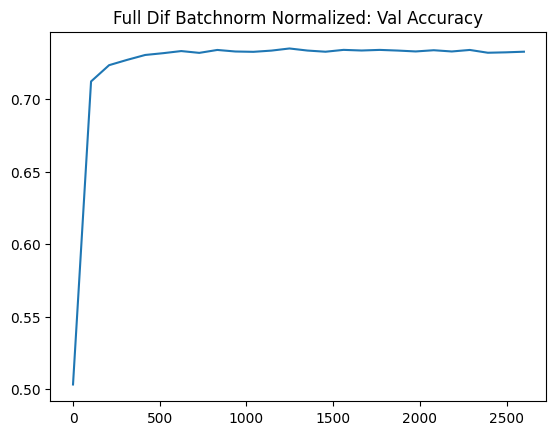

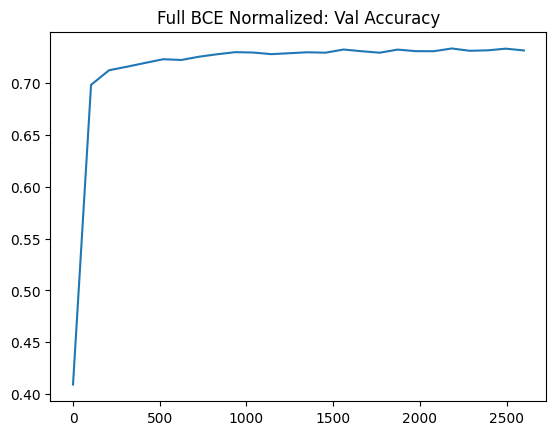

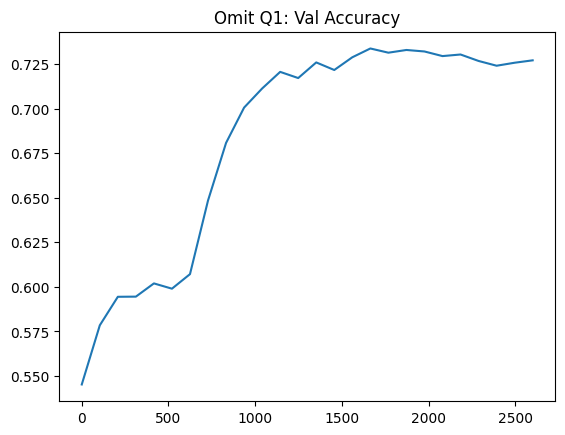

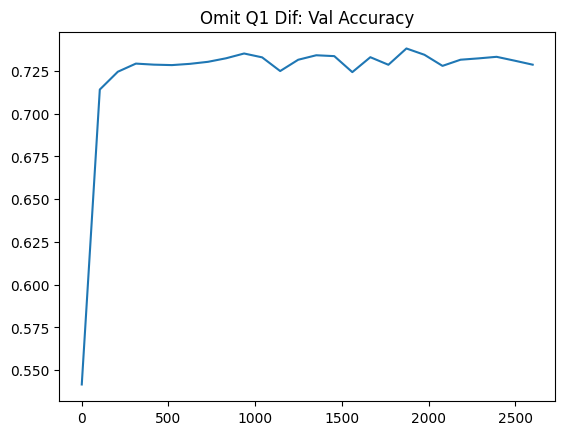

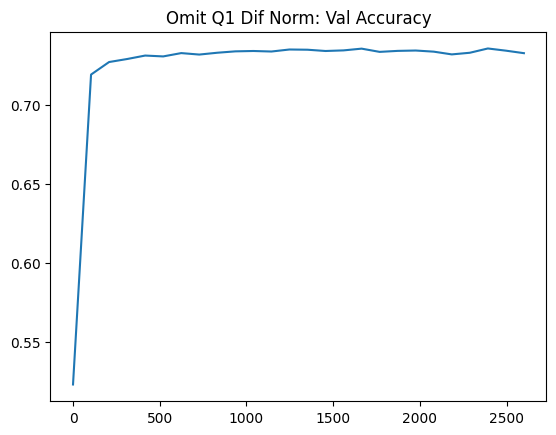

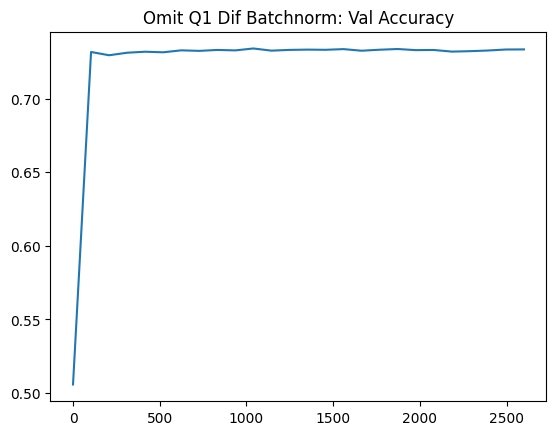

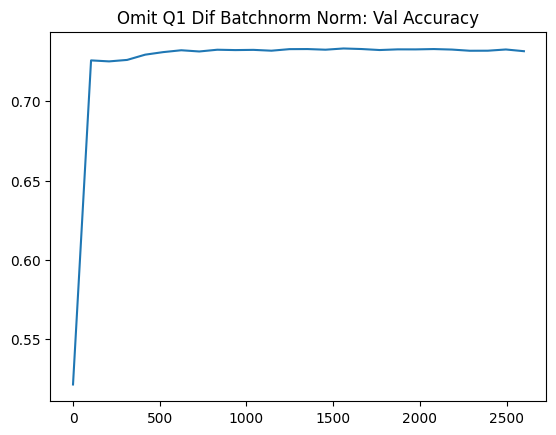

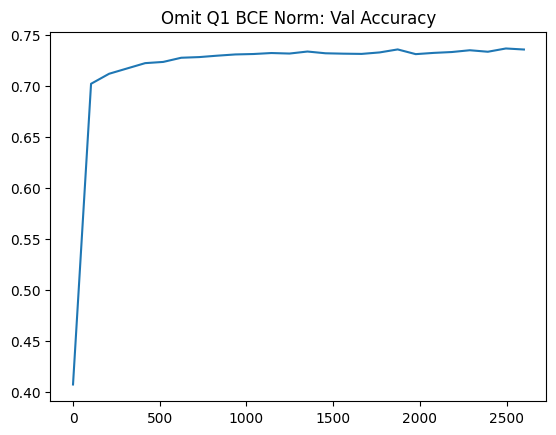

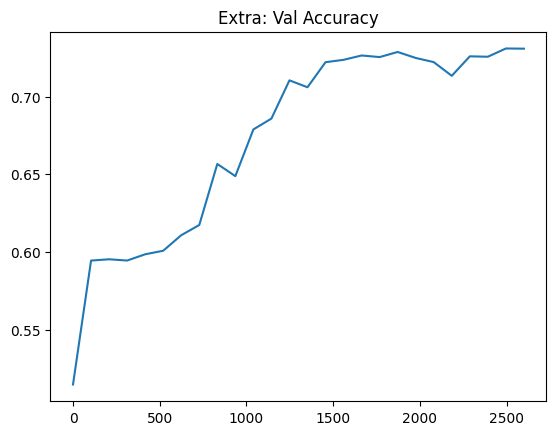

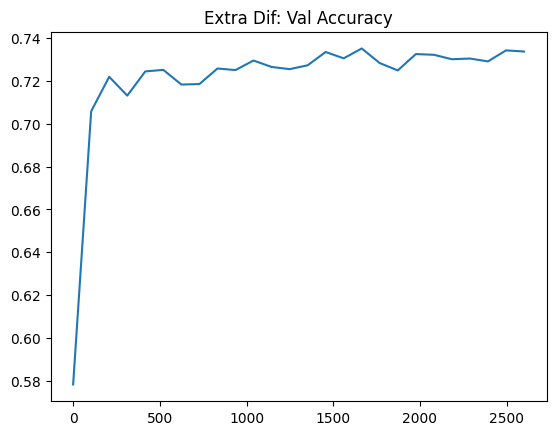

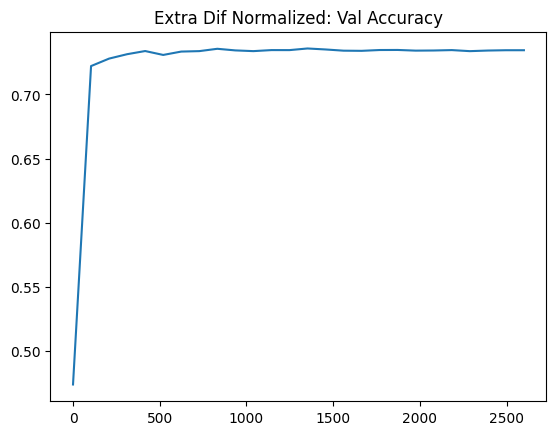

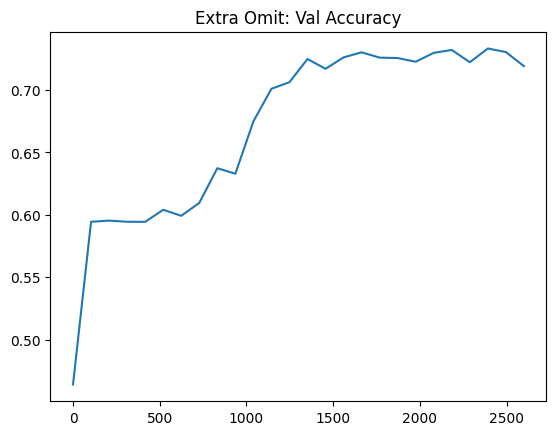

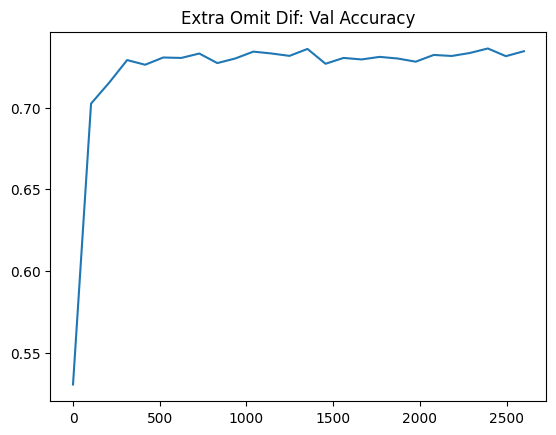

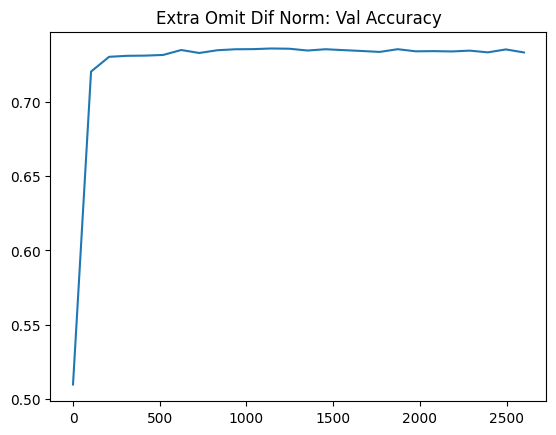

In [ ]:
batch_size = 32
hidden_layers = 2
intermediate_features = 90
input_features = 94
omit_input_features = 64
extra_input_features = 124
output_features_2 = 2
output_features_1 = 1
lr = .001
epochs = 3
interval = 100
num_cycles = 12
last_acc_num = 10
step = 0

# ADJUST EVERY TIME
total_steps = 18

results = []

step = progress_bar(step, total_steps)
results.append(run_model("Full", train_dataset, val_dataset, accuracy_2_outputs, BasicNet, input_features, output_features_2, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Full Dif", train_dataset_dif, val_dataset_dif, accuracy_1_output, BasicNet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Full Dif Batchnorm", train_dataset_dif, val_dataset_dif, accuracy_1_output, BatchNormNet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Full Dif Normalized", train_dataset_dif_norm, val_dataset_dif_norm, accuracy_1_output, BasicNet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Full Dif Batchnorm Normalized", train_dataset_dif_norm, val_dataset_dif_norm, accuracy_1_output, BatchNormNet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Full BCE Normalized", train_dataset_bce_norm, val_dataset_bce_norm, accuracy_BCE, BCENet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Omit Q1", train_dataset_omit_q1, val_dataset_omit_q1, accuracy_2_outputs, BasicNet, omit_input_features, output_features_2, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Omit Q1 Dif", train_dataset_dif_omit_q1, val_dataset_dif_omit_q1, accuracy_1_output, BasicNet, omit_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Omit Q1 Dif Norm", train_dataset_omit_q1_dif_norm, val_dataset_omit_q1_dif_norm, accuracy_1_output, BasicNet, omit_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Omit Q1 Dif Batchnorm", train_dataset_dif_omit_q1, val_dataset_dif_omit_q1, accuracy_1_output, BatchNormNet, omit_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Omit Q1 Dif Batchnorm Norm", train_dataset_omit_q1_dif_norm, val_dataset_omit_q1_dif_norm, accuracy_1_output, BatchNormNet, omit_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Omit Q1 BCE Norm", train_dataset_bce_norm_omit_q1, val_dataset_bce_norm_omit_q1, accuracy_BCE, BCENet, omit_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Extra", extra_train_dataset, extra_val_dataset, accuracy_2_outputs, BasicNet, extra_input_features, output_features_2, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Extra Dif", extra_train_dataset_dif, extra_val_dataset_dif, accuracy_1_output, BasicNet, extra_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Extra Dif Normalized", extra_train_dataset_dif_norm, extra_val_dataset_dif_norm, accuracy_1_output, BasicNet, extra_input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Extra Omit", extra_train_dataset_omit_q1, extra_val_dataset_omit_q1, accuracy_2_outputs, BasicNet, input_features, output_features_2, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Extra Omit Dif",extra_train_dataset_omit_q1_dif, extra_val_dataset_omit_q1_dif, accuracy_1_output, BasicNet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)
results.append(run_model("Extra Omit Dif Norm", extra_train_dataset_omit_q1_dif_norm, extra_val_dataset_omit_q1_dif_norm, accuracy_1_output, BasicNet, input_features, output_features_1, batch_size, num_cycles, interval, last_acc_num, epochs, intermediate_features, hidden_layers, lr))
step = progress_bar(step, total_steps)



print(" ")
for i in range(len(results)):
  print(results[i][1])

for i in range(len(results)):
  plot_val_acc(results[i][0], interval, results[i][2])

Full improvement: 1.0850125944584454
Full Dif improvement: 1.8173803526448373
Full Dif Batchnorm improvement: 1.8280856423173897
Full Dif Normalized improvement: 1.897355163727965
Full Dif Batchnorm Normalized improvement: 1.8089840470193241
Full BCE Normalized improvement: 1.6171284634760807


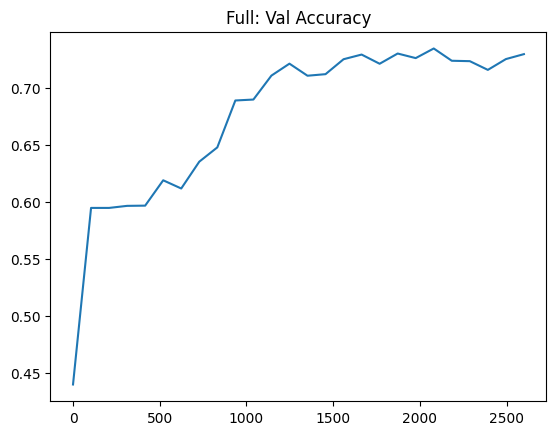

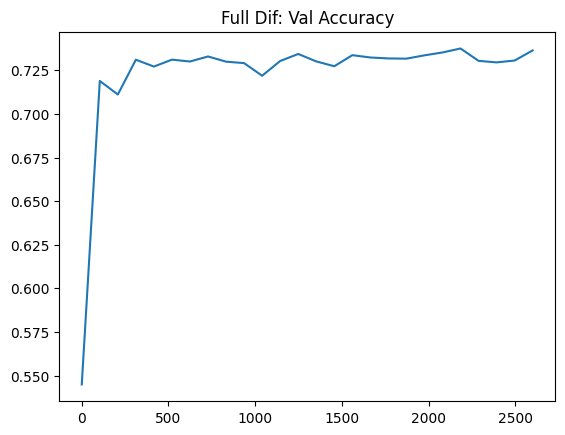

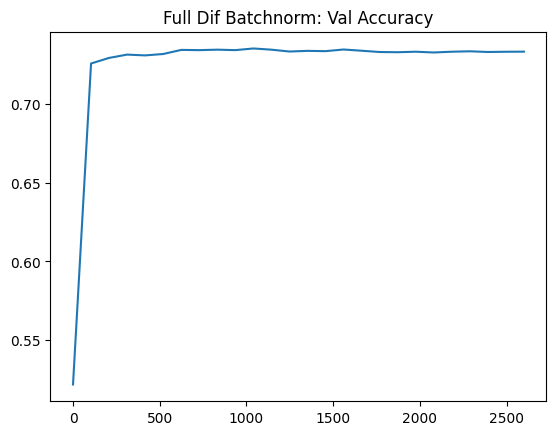

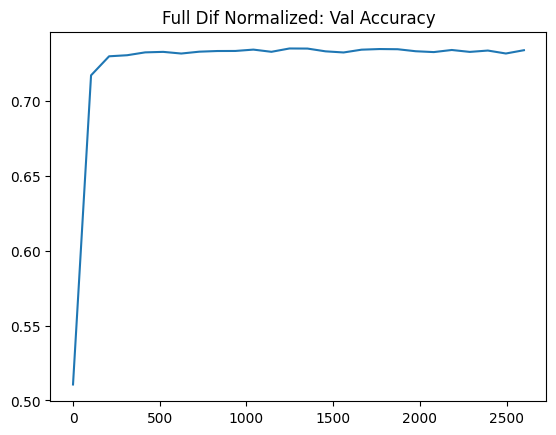

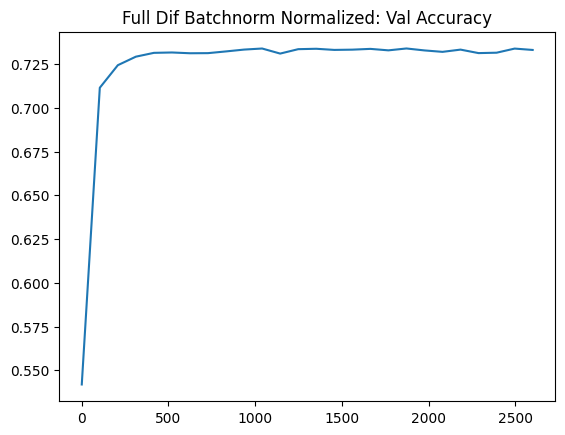

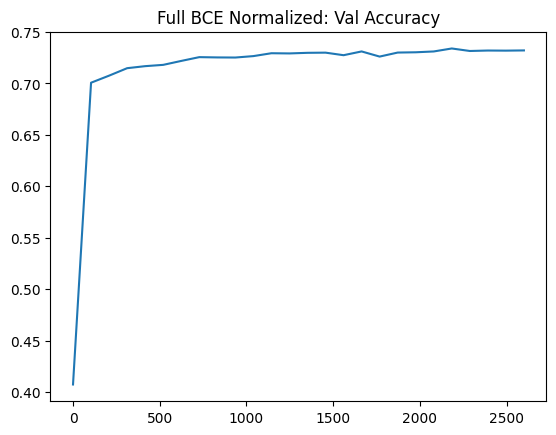

In [ ]:
for i in range(len(results)):
  print(results[i][1])

for i in range(len(results)):
  plot_val_acc(results[i][0], interval, results[i][2])

In [ ]:
model = TabNetRegressor(n_d = 5, n_a = 5, n_steps = 5, virtual_batch_size = 32, loss_fn = nn.MSELoss())
model.to(device)



In [ ]:
#Comparing 1 Output to 2 Output

# Hyperparameters
batch_size = 32
hidden_layers = 2
intermediate_features = 90
input_features = 94
omit_input_features = 64
output_features_2 = 2
output_features_1 = 1
learning_rate = .001
epochs = 2
val_interval_batches = 100
num_cycles = 3
num_val_accs_to_avg = 8


# Instantiate DataLoaders
train_dataloader_full = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
val_dataloader_full = DataLoader(val_dataset, batch_size = batch_size, shuffle = False)
omit_q1_train_dataloader = DataLoader(train_dataset_omit_q1, batch_size = batch_size, shuffle = True)
omit_q1_val_dataloader = DataLoader(val_dataset_omit_q1, batch_size = batch_size, shuffle = False)
dif_train_dataloader = DataLoader(train_dataset_dif, batch_size = batch_size, shuffle = True)
dif_val_dataloader = DataLoader(val_dataset_dif, batch_size = batch_size, shuffle = False)
dif_omit_q1_train_dataloader = DataLoader(train_dataset_dif_omit_q1, batch_size = batch_size, shuffle = True)
dif_omit_q1_val_dataloader = DataLoader(val_dataset_dif_omit_q1, batch_size = batch_size, shuffle = False)
dif_norm_dataloader = DataLoader(train_dataset_dif_norm, batch_size = batch_size, shuffle = True)
dif_norm_val_dataloader = DataLoader(val_dataset_dif_norm, batch_size = batch_size, shuffle = False)



full_accs = []
omit_q1_accs = []
dif_accs = []
dif_omit_q1_accs = []
batch_norm_accs = []
dif_norm_accs = []

val_accs_full_totals = []
val_accs_omit_q1_totals = []
val_accs_dif_totals = []
val_accs_dif_omit_q1_totals = []
batch_norm_accs_totals = []
dif_norm_accs_totals = []

step = 0
total_steps = num_cycles * 3

step = progress_bar(step, total_steps)

for i in range(num_cycles):

  # Instantiate Model
  model_full = BasicNet(input_features, intermediate_features, output_features_2, hidden_layers)
  model_full.to(device)
  model_omit_q1 = BasicNet(omit_input_features, intermediate_features, output_features_2, hidden_layers)
  model_omit_q1.to(device)
  model_dif = BasicNet(input_features, intermediate_features, output_features_1, hidden_layers)
  model_dif.to(device)
  model_dif_omit_q1 = BasicNet(omit_input_features, intermediate_features, output_features_1, hidden_layers)
  model_dif_omit_q1.to(device)
  model_batch_norm = BatchNormNet(input_features, intermediate_features, output_features_1, hidden_layers)
  model_batch_norm.to(device)
  model_dif_norm = BasicNet(input_features, intermediate_features, output_features_1, hidden_layers)
  model_dif_norm.to(device)


  # Instantiate Optimizer
  optimizer_full = optim.Adam(model_full.parameters(), lr = learning_rate)
  optimizer_omit_q1 = optim.Adam(model_omit_q1.parameters(), lr = learning_rate)
  optimizer_dif = optim.Adam(model_dif.parameters(), lr = learning_rate)
  optimizer_dif_omit_q1 = optim.Adam(model_dif_omit_q1.parameters(), lr = learning_rate)
  optimizer_batch_norm = optim.Adam(model_batch_norm.parameters(), lr = learning_rate)
  optimizer_dif_norm = optim.Adam(model_dif_norm.parameters(), lr = learning_rate)

  # Train
  # losses_full, accs_full, val_losses_full, val_accs_full = train(model_full, optimizer_full, epochs, train_dataloader_full, val_dataloader_full, val_interval_batches, accuracy_2_outputs)
  # step = progress_bar(progress_bar_length, step, total_steps)
  # losses_omit_q1, accs_omit_q1, val_losses_omit_q1, val_accs_omit_q1 = train(model_omit_q1, optimizer_omit_q1, epochs, omit_q1_train_dataloader, omit_q1_val_dataloader, val_interval_batches, accuracy_2_outputs)
  # step = progress_bar(progress_bar_length, step, total_steps)
  losses_dif, accs_dif, val_losses_dif, val_accs_dif = train(model_dif, optimizer_dif, epochs, dif_train_dataloader, dif_val_dataloader, val_interval_batches, accuracy_1_output)
  step = progress_bar(step, total_steps)
  # losses_dif_omit_q1, accs_dif_omit_q1, val_losses_dif_omit_q1, val_accs_dif_omit_q1 = train(model_dif_omit_q1, optimizer_dif_omit_q1, epochs, dif_omit_q1_train_dataloader, dif_omit_q1_val_dataloader, val_interval_batches, accuracy_1_output)
  # step = progress_bar(progress_bar_length, step, total_steps)
  losses_batch_norm, accs_batch_norm, val_losses_batch_norm, val_accs_batch_norm = train(model_batch_norm, optimizer_batch_norm, epochs, dif_train_dataloader, dif_val_dataloader, val_interval_batches, accuracy_1_output)
  step = progress_bar(step, total_steps)
  losses_dif_norm, accs_dif_norm, val_losses_dif_norm, val_accs_dif_norm = train(model_dif_norm, optimizer_dif_norm, epochs, dif_norm_dataloader, dif_norm_val_dataloader, val_interval_batches, accuracy_1_output)
  step = progress_bar(step, total_steps)


  # Calculate Max Validation Accuracies

  if i == 0:
      # val_accs_full_totals = val_accs_full
      # val_accs_omit_q1_totals = val_accs_omit_q1
      val_accs_dif_totals = val_accs_dif
      # val_accs_dif_omit_q1_totals = val_accs_dif
      val_accs_batch_norm_totals = val_accs_batch_norm
      val_accs_dif_norm_totals = val_accs_dif_norm
  else:
      # val_accs_full_totals = np.add(val_accs_full_totals, val_accs_full)
      # val_accs_omit_q1_totals = np.add(val_accs_omit_q1_totals, val_accs_omit_q1)
      val_accs_dif_totals = np.add(val_accs_dif_totals, val_accs_dif)
      # val_accs_dif_omit_q1_totals = np.add(val_accs_dif_omit_q1_totals, val_accs_dif_omit_q1)
      val_accs_batch_norm_totals = np.add(val_accs_batch_norm_totals, val_accs_batch_norm)
      val_accs_dif_norm_totals = np.add(val_accs_dif_norm_totals, val_accs_dif_norm)

  # full_accs.append(max(val_accs_full))
  # omit_q1_accs.append(max(val_accs_omit_q1))
  dif_accs.append(sum(val_accs_dif[-num_val_accs_to_avg:]) / num_val_accs_to_avg)
  # dif_omit_q1_accs.append(max(val_accs_dif_omit_q1))
  batch_norm_accs.append(sum(val_accs_batch_norm[-num_val_accs_to_avg:]) / num_val_accs_to_avg)
  dif_norm_accs.append(sum(val_accs_dif_norm[-num_val_accs_to_avg:]) / num_val_accs_to_avg)

# Calculate Average Max
# full_accs_avg = sum(full_accs) / len(full_accs)
# omit_q1_accs_avg = sum(omit_q1_accs) / len(omit_q1_accs)
dif_accs_avg = sum(dif_accs) / len(dif_accs)
# dif_omit_q1_accs_avg = sum(dif_omit_q1_accs) / len(dif_omit_q1_accs)
batch_norm_accs_avg = sum(batch_norm_accs) / len(batch_norm_accs)
dif_norm_accs_avg = sum(dif_norm_accs) / len(dif_norm_accs)

# val_accs_full_totals_avg = np.array(val_accs_full_totals) / num_cycles
# val_accs_omit_q1_totals_avg = np.array(val_accs_omit_q1_totals) / num_cycles
val_accs_dif_totals_avg = np.array(val_accs_dif_totals) / num_cycles
# val_accs_dif_omit_q1_totals_avg = np.array(val_accs_dif_omit_q1_totals) / num_cycles
val_accs_batch_norm_totals_avg = np.array(val_accs_batch_norm_totals) / num_cycles
val_accs_dif_norm_totals_avg = np.array(val_accs_dif_norm_totals) / num_cycles

print("")
# Print Max Validation Accuracies
# print("Full Above Baseline " + str((full_accs_avg - baseline_accuracy(val_dataset))*100))
# print("Omit Q1 Above Baseline " + str((omit_q1_accs_avg - baseline_accuracy(val_dataset))*100))
print("Dif Above Baseline " + str((dif_accs_avg - baseline_accuracy(val_dataset))*100))
# print("Dif Omit Q1 Above Baseline " + str((dif_omit_q1_accs_avg - baseline_accuracy(val_dataset))*100))
print("Batch Norm Above Baseline " + str((batch_norm_accs_avg - baseline_accuracy(val_dataset))*100))
print("Dif Norm Above Baseline " + str((dif_norm_accs_avg - baseline_accuracy(val_dataset))*100))

# Plot Average Validation Accuracy Curves
# plot_val_acc(val_accs_full_totals_avg, val_interval_batches)
# plot_val_acc(val_accs_omit_q1_totals_avg, val_interval_batches)
plot_val_acc(val_accs_dif_totals_avg, val_interval_batches)
# plot_val_acc(val_accs_dif_omit_q1_totals_avg, val_interval_batches)
plot_val_acc(val_accs_batch_norm_totals_avg, val_interval_batches)
plot_val_acc(val_accs_dif_norm_totals_avg, val_interval_batches)



In [ ]:
# Without Q1 Dataset

# Hyperparameters
batch_size = 32
hidden_layers = 2
intermediate_features = 90
input_features = 64
output_features = 2
learning_rate = .001
epochs = 3
val_interval_batches = 100


# Instantiate DataLoaders

omit_q1_train_dataloader = DataLoader(train_dataset_omit_q1, batch_size = batch_size, shuffle = True)
omit_q1_val_dataloader = DataLoader(val_dataset_omit_q1, batch_size = batch_size, shuffle = False)

# Instantiate Model
model = BasicNet(input_features, intermediate_features, output_features, hidden_layers)
model.to(device)

# Instantiate Optimizer
optimizer = optim.Adam(model.parameters(), lr = learning_rate)

# Train
losses, accs, val_losses, val_accs = train(model, optimizer, epochs, omit_q1_train_dataloader, omit_q1_val_dataloader, val_interval_batches)

# Plot

plot_results(losses, accs, val_losses, val_accs, val_interval_batches)

In [ ]:
# Looping
batch_size = 32
hidden_layers = 1
intermediate_features = 1000
input_features = 94
output_features = 2
learning_rate = .001
epochs = 3
val_interval_batches = 100

results = []


for j in range(10):
  model = BasicNet(input_features, intermediate_features, output_features, hidden_layers)
  model.to(device)

  optimizer = optim.Adam(model.parameters(), lr = learning_rate)

  losses, accs, val_losses, val_accs = train(model, optimizer, epochs, train_dataloader, val_dataloader, val_interval_batches)
  max_acc = max(val_accs)

  result = (hidden_layers, intermediate_features, max_acc)
  results.append(result)
  intermediate_features += 20


print(results)
